# DBSCAN Topic Modeling

This notebook performs topic modeling on a set of VMware last-chance searches. We'll cluster using DBSCAN on TF-IDF vectors.

## Input Data

In [1]:
import sys
sys.path.append('..')

from scripts import corpora

In [2]:
last_month = corpora.load('../corpora/vmware-last-month')
vsphere_65 = corpora.load('../corpora/vsphere-6.5-last-month')

## Parameter Analysis

DBSCAN takes two parameters: `ε` and `minPts`. `ε` is the maximum distance between items for them to be considered in the same cluster. `minPts` is the minimum number of items per cluster.

`ε` should be as small as possible. The [original DBSCAN paper](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf) gives suggestions for picking `ε`.

> For a given k we define a function k-dist from the database D to the real numbers, mapping each point to the distance from its k-th nearest neighbor. When sorting the points of the database in descending order of their k-dist values, the graph of this function gives some hints concerning the density distribution in the database. We call this graph the sorted k-dist graph.

Let's start by vectorizing our data.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', min_df=2, max_df=0.1)
vectors = vectorizer.fit_transform([search.body for search in vsphere_65])

Next, let's create an adjacency matrix for a weighted distance graph. Every cell will represent the distance (edge weight) between two searches (nodes).

In [30]:
from sklearn.metrics.pairwise import pairwise_distances

distances = pairwise_distances(vectors, metric='cosine')

For each point, we need to find the distance to the k-th nearest neighbor.

In [31]:
k = 4
k_dists = [sorted(distances[point])[k] for point in range(len(distances))]

Finally, time for the k-dist graph!

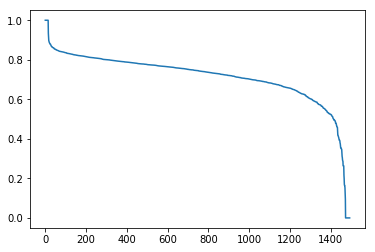

In [33]:
import matplotlib.pyplot as plt

plt.plot(sorted(k_dists, reverse=True))

The main *elbow* happens at around `0.6`. This seems like a good starting place for `ε`.

## Algorithm

We'll leverage Scikit-learn's *DBSCAN* class. I've chosen cosine-similarity as my distance function.

Vectorization will happen through *TfidfVectorizer*. I've set `min_df` to 2 (words must appear in at least two documents) and `max_df` to 0.1 (words can't appear in more than 10% of documents). For this first round I'm pulling unigrams.

In [3]:
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
class DensityClusterer:
    
    def __init__(self, eps, min_samples=5, min_df=2, max_df=0.1, ngram_range=(1, 1)):
        self.corpus = None
        self.model = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine', n_jobs=-1)
        self.vectorizer = TfidfVectorizer(stop_words='english', min_df=min_df,
                                          max_df=max_df, ngram_range=ngram_range)
    
    def cluster(self, corpus):
        self.corpus = corpus
        vectors = self.vectorizer.fit_transform(corpus)
        self.model.fit(vectors)
        
    def n_clusters(self):
        return max(self.model.labels_)
        
    def get_cluster(self, cluster_id):
        return [document for index, document in enumerate(self.corpus)
                if self.model.labels_[index] == cluster_id]

In [5]:
clusterer = DensityClusterer(eps=0.6)
clusterer.cluster([search.body for search in vsphere_65])

In [6]:
from pandas import DataFrame

clusters = DataFrame([{'Cluster ID': cluster_id, 'Size': len(clusterer.get_cluster(cluster_id))}
                      for cluster_id in range(clusterer.n_clusters())])
clusters.to_csv('../output/dbscan/vsphere-6.5-last-month/unigram/clusters.csv', index=False)
clusters

,Cluster ID,Size
0,0,17
1,1,79
2,2,136
3,3,9
4,4,10
5,5,6
6,6,22
7,7,9
8,8,6
9,9,9


In [7]:
documents = DataFrame([{'Cluster ID': cluster_id, 'Search': body}
                       for cluster_id in range(clusterer.n_clusters())
                       for body in clusterer.get_cluster(cluster_id)])
documents.to_csv('../output/dbscan/vsphere-6.5-last-month/unigram/documents.csv', index=False)
documents

,Cluster ID,Search
0,0,TEST TEST TEST
1,0,test
2,0,TEST TEST TEST
3,0,test
4,0,test
5,0,Test
6,0,test testtest
7,0,TEST TEST TEST
8,0,Test
9,0,TEST TEST TEST


## N-Gram Features

In [26]:
clusterer = DensityClusterer(eps=0.5, ngram_range=(1, 2))
clusterer.cluster([search.body for search in vsphere_65])

In [27]:
from pandas import DataFrame

clusters = DataFrame([{'Cluster ID': cluster_id, 'Size': len(clusterer.get_cluster(cluster_id))}
                      for cluster_id in range(clusterer.n_clusters())])
clusters.to_csv('../output/dbscan/vsphere-6.5-last-month/n-gram/clusters.csv', index=False)
clusters

,Cluster ID,Size
0,0,17
1,1,6
2,2,11
3,3,5
4,4,13
5,5,5
6,6,6
7,7,6


In [28]:
documents = DataFrame([{'Cluster ID': cluster_id, 'Search': body}
                       for cluster_id in range(clusterer.n_clusters())
                       for body in clusterer.get_cluster(cluster_id)])
documents.to_csv('../output/dbscan/vsphere-6.5-last-month/n-gram/documents.csv', index=False)
documents

,Cluster ID,Search
0,0,TEST TEST TEST
1,0,test
2,0,TEST TEST TEST
3,0,test
4,0,test
5,0,Test
6,0,test testtest
7,0,TEST TEST TEST
8,0,Test
9,0,TEST TEST TEST


## Next Steps

* Try clustering with more data. Filter to get the most recent month.
  * e.g. Model with 6 months, post process to 1 month
* Determine *key terms* or *top n-grams* for each cluster.
* Experiment with other corpora.
* Experiment with different `ε` and `minPts` parameters.